<a href="https://colab.research.google.com/github/tanyakuznetsova/Multidimensional-Scaling-of-European_Cities/blob/main/Multidimensional_scaling_of_European_Cities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experiments with multidimensional scaling

In this notebook I will look at how Multidimensional Scaling, both in its classical manual implementation and from ```sklearn``` library, can be used to obtain a two-dimensional embedding of twenty European cities.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import manifold
from sklearn.decomposition import PCA

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The file european_cities.txt contains pairwise distances between Europearn cities - these distances are given in kilometers 'as the crow flies':

In [3]:
data = np.genfromtxt('/content/drive/My Drive/european_cities.txt')

In [4]:
names = ['Berlin', 'Brussels', 'Helsinki', 'London', 'Madrid', 'Moscow', 'Paris', 'Rejkjavik', 'Rome', 'Stockholm', 'Oslo', 'Edinburgh', 'Vilnius', 'Warsaw', 'Kyiv', 'Zurich', 'Vienna', 'Bucharest', 'Lisbon', 'Athens']

In [5]:
data

array([[   0.,  651., 1105.,  932., 1870., 1608.,  878., 2388., 1184.,
         810.,  838., 1141.,  818.,  516., 1205.,  671.,  524., 1294.,
        2314., 1804.],
       [ 651.,    0., 1648.,  321., 1316., 2253.,  264., 2129., 1174.,
        1280., 1085.,  756., 1465., 1159., 1837.,  492.,  914., 1770.,
        1714., 2090.],
       [1105., 1648.,    0., 1821., 2948.,  892., 1909., 2416., 2202.,
         396.,  787., 1705.,  610.,  915., 1137., 1775., 1439., 1751.,
        3361., 2469.],
       [ 932.,  321., 1821.,    0., 1263., 2501.,  343., 1891., 1434.,
        1433., 1154.,  534., 1723., 1448., 2135.,  776., 1235., 2091.,
        1586., 2392.],
       [1870., 1316., 2948., 1263.,    0., 3440., 1053., 2892., 1364.,
        2593., 2387., 1728., 2661., 2290., 2864., 1246., 1809., 2472.,
         503., 2370.],
       [1608., 2253.,  892., 2501., 3440.,    0., 2486., 3308., 2377.,
        1227., 1644., 2509.,  790., 1151.,  755., 2194., 1670., 1499.,
        3907., 2232.],
       [ 8

The function `cMDS` implements the classic multidimensional scaling (MDS) algorithm, taking as input a matrix of interpoint distances $D$ and a target embedding dimension $k$.

This is done with the help of the centering 'Gram' matrix B, which must be positive semidefinite:

$B = -\dfrac{1}{2}HDH$ which is positive semidefinite, and where
$H = I_n - \dfrac{1}{n}11^T$.

This is the basis of the most widely used classical multidimensional scaling algorithm.

In [6]:
def cMDS(D, k):
    n = D.shape[0]

    H = np.identity(n) - (1/n)*np.ones((n, n))

    #B = -0.5*H.dot(D**2).dot(H)
    B = -0.5*H @ D @ H

    w, v = np.linalg.eigh(B)
    idx = np.argsort(w)[::-1] #sorting in the decreasing order
    eigvals = w[idx]
    eigvecs = v[:, idx]

    #selecting top eigenvalues and eigenvectors
    lamb = np.diag(np.sqrt(eigvals[:k]))
    V = eigvecs[:, :k]
    X = np.dot(lamb, np.transpose(V))

    return X.T

The function `plot` takes a 2-d embedding of the points and plots them, annotating each
point with the corresponding city name.

In [7]:
def plot(embeddings, algorithm):
    plt.figure(figsize = (8, 6))
    plt.style.use('ggplot')
    plt.scatter(embeddings[:, 0], embeddings[:, 1],
                #c = 'black',
                marker = '.'
                )
    for i, name in enumerate(names):
        plt.annotate(name, (embeddings[:, 0][i], embeddings[:, 1][i]),
                     size = 10,
                     xytext = (-2, 6),
                     textcoords = 'offset points',
                     c = 'black')
    plt.grid(True)
    plt.xlabel('First dimension')
    plt.ylabel('Second dimension')
    plt.title(f'Distances between European cities, {algorithm}')
    plt.tight_layout()

    plt.show()

In [8]:
X  = cMDS(data, 2)

In [9]:
X.shape

(20, 2)

In [10]:
X

array([[ -2.78044638,   1.679114  ],
       [ 11.80845156,   2.18645517],
       [-17.19747628,  14.31310472],
       [ 16.08641715,   5.92066256],
       [ 26.29824036, -11.1467833 ],
       [-25.4293693 ,   4.12236437],
       [ 15.8069457 ,  -0.8565988 ],
       [ 14.01224577,  29.00267622],
       [  5.0873227 , -19.23649292],
       [-11.37027537,  15.10576151],
       [ -3.68934215,  17.88299043],
       [ 13.75262862,  15.43571284],
       [-18.57364249,   3.5481147 ],
       [-13.27007529,  -1.29459191],
       [-21.8621746 ,  -6.06057229],
       [  8.339873  ,  -7.70645022],
       [ -4.38112285,  -9.52068767],
       [-14.71688994, -18.03573096],
       [ 30.2071314 ,  -9.27881344],
       [ -8.12844161, -26.06023499]])

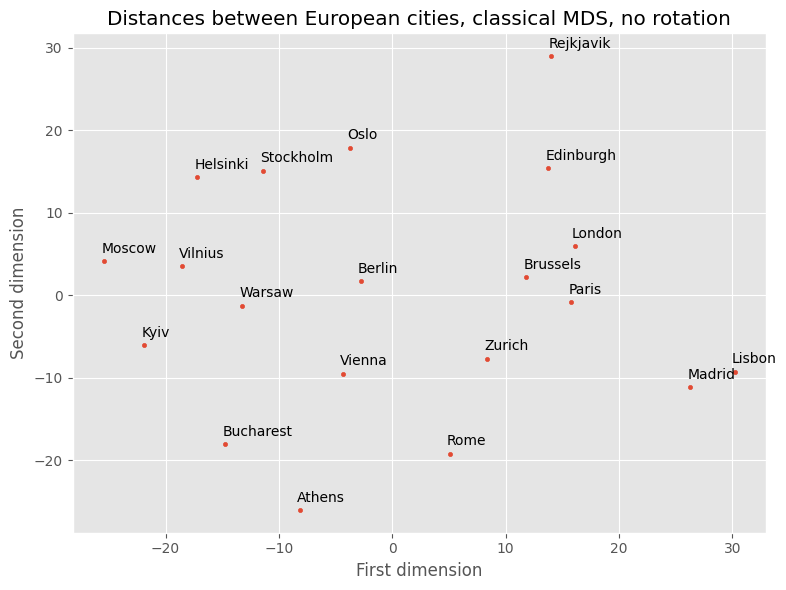

In [11]:
plot(X, algorithm = 'classical MDS, no rotation')

This does not look like the world map we are used to!

The map appears to be skewed at an angle, and, additionally, it is mirrored. Interestingly enough, to the MDS algorith, such conventions that we take for granted, such as directions like North and South, East and West, are completely irrelevant. This is as though an alien was looking down on the planet Earth from the space, unaware of these notions. The MDS algorithm is strictly concerned with preserving the inter-point distances and nothing else. This is its inherent quality and may be viewed as the cost of dimensionality reduction.

The function `rotate_MDS` helps achieve a rotated version of points that fits the map more closely. It takes a 2-d data set and an angle in degrees, and rotates each of the points through that angle by multiplying a point by the rotation matrix
$ \begin{bmatrix} \cos \theta & -\sin \theta \\ \in \theta & \cos \theta \end{bmatrix} $

In [12]:
from math import sin, cos, radians

def rotate_MDS(embeddings, angle,
               mirror = True):

    center = (0, 0)

    angle = radians(angle)
    #shift to make the center
    rotated_X = (embeddings[0] - center[0],
                embeddings[1] - center[1])
    #actually rotate
    rotated_X = (rotated_X[0]*cos(angle) + rotated_X[1]*(-sin(angle)),
                 rotated_X[0]*sin(angle) + rotated_X[1]*cos(angle))
    #undo the shifting
    rotated_X = (rotated_X[0] + center[0],
                 rotated_X[1] + center[1])

    if mirror:
        rotated_X = (-rotated_X[0], rotated_X[1]) #changing the sign of the x coordinate to mirror

    return rotated_X

In [13]:
rotated_embeddings = []

for x in X:

    rotated_points = rotate_MDS(x, angle = 5,
                                mirror = True)
    rotated_embeddings.append(rotated_points)

rotated_embeddings = np.asarray(rotated_embeddings)

In [14]:
rotated_embeddings

array([[  2.91621037,   1.4303926 ],
       [-11.57295472,   3.20730941],
       [ 18.37950396,  12.75978022],
       [-15.50918374,   7.30015628],
       [-27.1696738 ,  -8.81232375],
       [ 25.6918906 ,   1.89036196],
       [-15.821453  ,   0.52432691],
       [-11.43117516,  30.11355997],
       [ -6.74453473, -18.71990287],
       [ 12.64356191,  14.05729473],
       [  5.2339084 ,  17.4933929 ],
       [-12.35498469,  16.57559585],
       [ 18.81220274,   1.91581344],
       [ 13.10674752,  -2.44622887],
       [ 21.25076875,  -7.94292404],
       [ -8.97979866,  -6.95025702],
       [  3.53466875,  -9.8662986 ],
       [ 13.08897021, -19.24976103],
       [-30.90088602,  -6.61077978],
       [  5.8262113 , -26.6695083 ]])

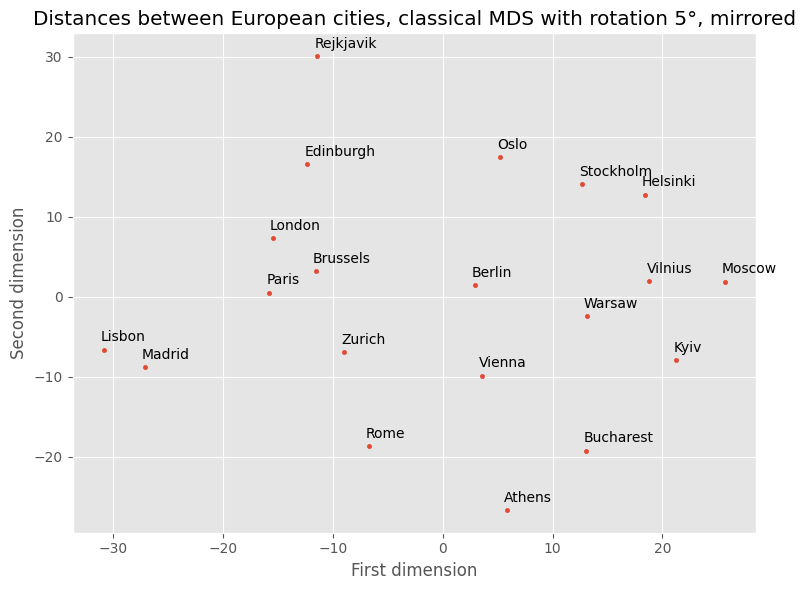

In [15]:
plot(rotated_embeddings,
     algorithm = 'classical MDS with rotation 5°, mirrored')

This looks a lot like the map of Europe we are familiar with.

Another algorithm for multidimensional scaling from `sklearn`, which works by defining a "stress function" that captures the disparity between the specified interpoint distances and a given embedding; this stress function is then minimized using gradient descent.

In [16]:
mds = manifold.MDS(n_components=2,
                   #random_state=0, #gives a pretty accurate rotation
                   dissimilarity = 'precomputed',
                   normalized_stress = 'auto')

mds_embedding = mds.fit_transform(data)

In [17]:
def is_symmetric(array):
    return np.allclose(array, array.T)


is_symmetric(data)

True

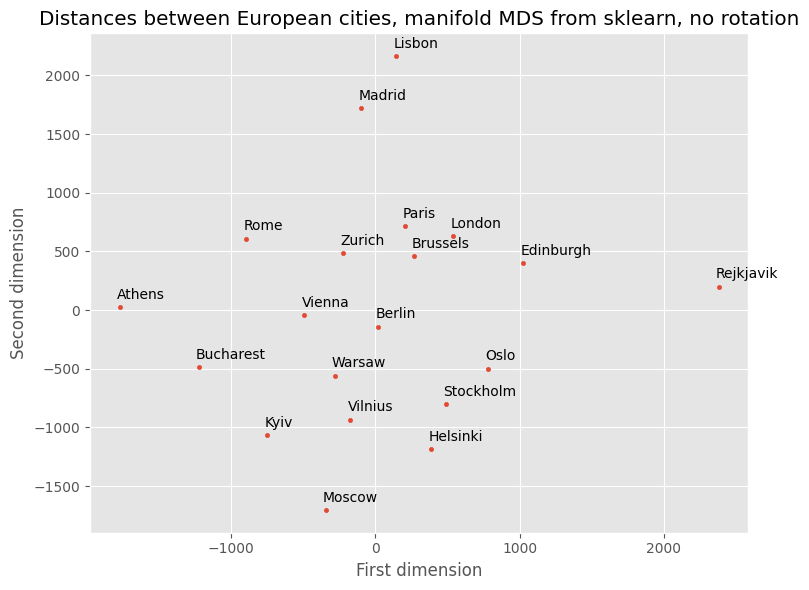

In [18]:
plot(mds_embedding,
    algorithm = 'manifold MDS from sklearn, no rotation')

This gives a fairly recognizable map straight out of the box, but it looks like the MDS algorithm from ```sklearn``` also needs to be rotated to resemble the atlas map.

In [19]:
tweaked_mds_embeddings = []

for x in mds_embedding:

    rotated_points = rotate_MDS(x, 90, mirror = False)
    tweaked_mds_embeddings.append(rotated_points)

tweaked_mds_embeddings = np.asarray(tweaked_mds_embeddings)

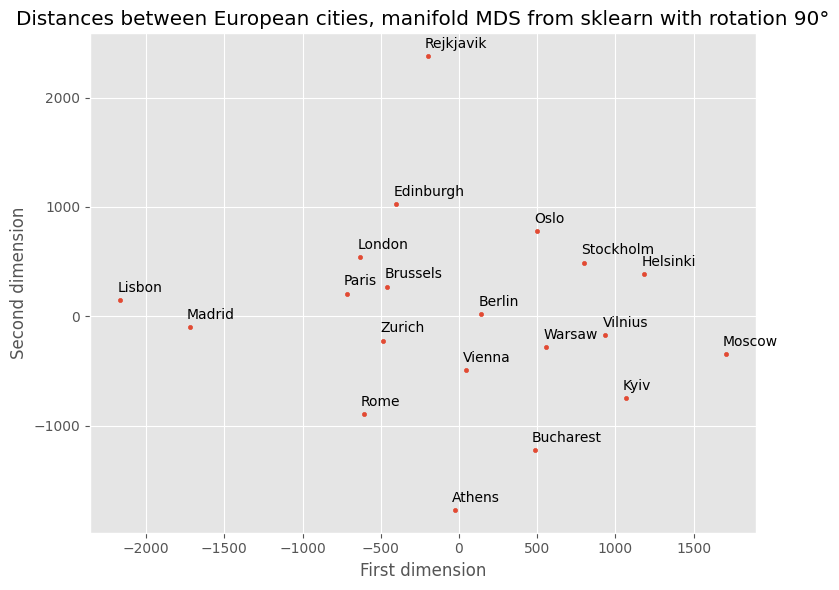

In [20]:
plot(tweaked_mds_embeddings,
    algorithm = 'manifold MDS from sklearn with rotation 90°')

This once again looks very much like the recognizable map with the correct approximate positioning along the geographic coordinates.

# PCA comparison

Out of interest, I also wanted to see how MDS compares to another dimensionality reducing technique, Principal Component Analysis.

While MDS is concerned with preserving pairwise distances between data points in a lower-dimensional space, PCA aims to find the principal components along the directions of maximum variance in the data. They each have distinct optimization objectives, so let's put it to the test:

In [21]:
pca = PCA(n_components = 2, random_state = 100)

reduced_data = pca.fit_transform(data)

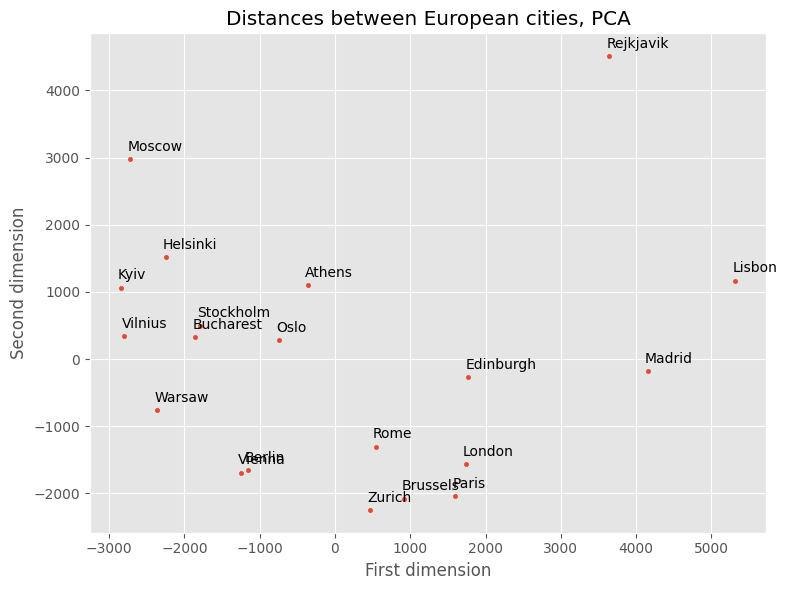

In [22]:
plot(reduced_data, "PCA")

In [23]:
pca_embeddings = []

for x in reduced_data:

    rotated_points = rotate_MDS(x, angle = 25,
                                mirror = True)
    pca_embeddings.append(rotated_points)

pca_embeddings = np.asarray(pca_embeddings)

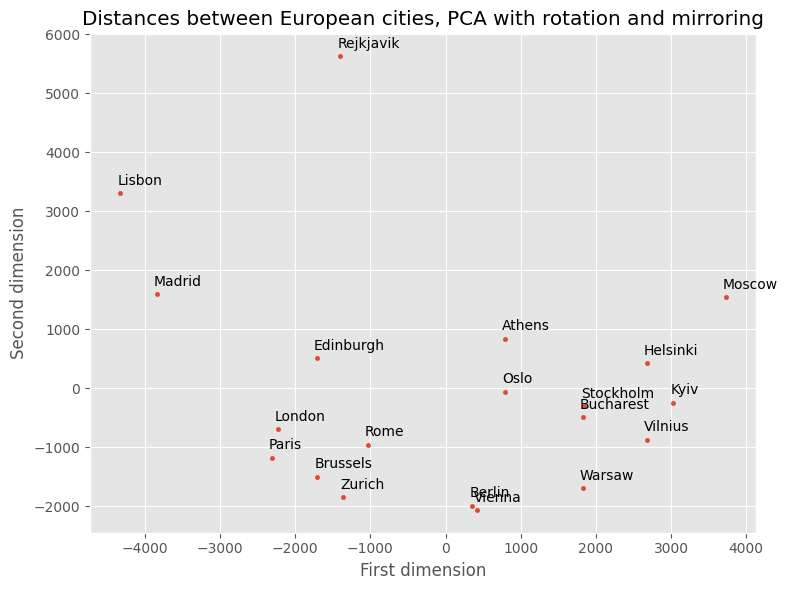

In [24]:
plot(pca_embeddings, 'PCA with rotation and mirroring')

In this particular case, the MDS algorithm definitely outperformed PCA. The visualization that results from applying PCA to the data is not nearly as accurate and representative of the actual map of Europe, although most of the proximity relationship is captured with a decent degree of accuracy. This is expected, as PCA is best used on data with that is highly correlated, since it preserves the covariance rather thatn the distances.
The MDS algorithm, being specifically concerned with preserving the distances, is the clear winner in this competition.